# Shared Antithetic Integral Controller
This notebook generates the approximated moment equations for the _Shared Antithetic Integral Controller_ case study of the LPAC paper.
As explained in the Supplementary Information section *G*, the bulk chemistry is _virtualised_, i.e. it is represented as molecules belonging to compartments and following compartmentalised reactions which however are equivalent to bulk mass-action dynamics.

The bulk transition network is:
$$
\begin{align}
	[x] &\xrightarrow{h_D(n; x,y)} [y] + [x-y] & \text{(Division)} \notag \\
	[x] + [x'] &\xrightarrow{h_A(n; x)} [x] & \text{(Apoptosis)} \notag \\
	[x] &\xrightarrow{h_p(n; x)} [x + 1] & \text{(Production)} \notag \\
	[x] &\xrightarrow{h_d(n; x)} [x - 1] & \text{(Degradation)} \notag \\
	\emptyset &\xrightarrow{h_{ref}(n; x)} Z_1 & \text{(Reference)} \notag \\
	Z_1 + [x] &\xrightarrow{h_{act}(n; x)} Z_1 + [x + 1] & \text{(Actuation)} \notag \\
	[x] &\xrightarrow{h_{meas}(n; x)} [x] + Z_2 & \text{(Measurement)} \notag \\
	Z_1 + Z_2 &\xrightarrow{h_{comp}(n; x)} \emptyset & \text{(Comparison)} \notag
\end{align}
$$

This is then virtualised as compartmentalised dynamics.
The internal compartment state becomes a 3-tuple:
$$
x = (Z_1, Z_2, Q)
$$
where $Z_1,Z_2$ are the bulk species, distributed across compartments, and $Q$ is the true internal species.

The transition network becomes:
$$
\begin{align}
	[x] &\xrightarrow{h_D(n; x,y)} [y] + [x-y] & \text{(Division)} \notag \\
	[x] + [x'] &\xrightarrow{h_A(n; x)} [x + (x'_1,x'_2,0)] & \text{(Apoptosis)} \notag \\
	[x] &\xrightarrow{h_p(n; x)} [x + (0,0,1)] & \text{(Production)} \notag \\
	[x] &\xrightarrow{h_d(n; x)} [x - (0,0,1)] & \text{(Degradation)} \notag \\
	[x] &\xrightarrow{h_{ref}(n; x)} [x + (1,0,0)] & \text{(Reference)} \notag \\
	[x] &\xrightarrow{h_{act}(n; x)} [x + (0,0,1)] & \text{(Actuation)} \notag \\
	[x] &\xrightarrow{h_{meas}(n; x)} [x + (0,1,0)] & \text{(Measurement)} \notag \\
	[x] &\xrightarrow{h_{comp_1}(n; x)} [x + (-1,-1,0)] & \text{(Comparison 1)} \notag \\
	[x] + [x'] &\xrightarrow{h_{comp_2}(n; x,x')} [x + (-1,0,0)] \notag \\
	& \phantom{\xrightarrow{h_{comp_2}(n; x,x')}} + [x' + (0,-1,0)] & \text{(Comparison 2)} \notag
\end{align}
$$

with the following propensity functions:
$$
\begin{align}
	h_D(n; x,y) &= k_D \, \pi_D(y \mid x) \, x_3 \, n_x \\
	h_A(n; x,x') &= k_A \, \frac{n_x (n_{x'} - \delta_{x,x'})}{1 + \delta_{x,x'}} \\
	h_p(n; x) &= k_p \, n_x \\
	h_d(n; x) &= k_d \, x_3 \, n_x \\
	h_{ref}(n; x) &= \frac{k_{ref}}{N} \, n_x \\
	h_{act}(n; x) &= k_{act} \, M^{1,0,0} \, n_x \\
	h_{meas}(n; x) &= k_{meas} \, x_3 \, n_x \\
	h_{comp_1}(n; x) &= k_{comp_1} \, x_1 x_2 \, n_x \\
\end{align}
$$

In [1]:
# import sys
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install sympy
# !{sys.executable} -m pip install scipy
# !{sys.executable} -m pip install matplotlib

In [2]:
# Remove matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# initialize sympy printing (for latex output)
from sympy import init_printing, Symbol
init_printing()

# import functions and classes for compartment models
import sys
sys.path.insert(0, "./compartor") #use local copy
from compartor import *

# Define shorthands for Moment and Expectation
M, E = Moment, Expectation

Here, we illustrate how to export the moment equations in LaTeX format or generate code for simulations.

We consider again the exemplary model of the paper and derive moments equations with the automated function.

In [4]:
from sympy import symbols, log, exp, sin, cos, tan
x = Content('x')
y = Content('y')
z = Content('z')

# Here we use 2 internal variables as bulk.
# The legend of internal states is:
# x = (Z1, Z2, Q)

pi_D0 = OutcomeDistribution.Uniform(Symbol("\pi_{D0}(y|x)"), y[0], 0, x[0])
pi_D1 = OutcomeDistribution.Uniform(Symbol("\pi_{D1}(y|x)"), y[1], 0, x[1])
pi_D2 = OutcomeDistribution.Uniform(Symbol("\pi_{D2}(y|x)"), y[2], 0, x[2])
pi_D = OutcomeDistribution.CombineIndependent(Symbol("\pi_D(y|x)"), pi_D0, pi_D1, pi_D2)

Division  = TransitionClass( [x] -to> [y]+[x-y], 'k_D', name='D', g=x[2], pi=pi_D )
Apoptosis = TransitionClass( [x]+[y] -to> [x + (y[0],y[1],0)], 'k_A', name='A', g=1)

Reference = TransitionClass( [x] -to> [x + (1,0,0)], 'k_ref', name='ref', g=1/M(0,0,0) )
Measurement = TransitionClass( [x] -to> [x + (0,1,0)], 'k_meas', name='meas', g=x[2] )

Comparison1 = TransitionClass( [x] -to> [x + (-1,-1,0)], 'k_comp1', name='comp1', g=x[0]*x[1] )
Comparison2 = TransitionClass( [x]+[y] -to> [x + (-1,0,0)]+[y + (0,-1,0)], 'k_comp2', name='comp2', g=x[0]*y[1] )

Actuation = TransitionClass( [x] -to> [x + (0,0,1)], 'k_act', name='act', g=M(1,0,0) )

prodX = TransitionClass( [x] -to> [x + (0,0,1)], 'k_1', name='prodX', g=1 )
degrX = TransitionClass( [x] -to> [x + (0,0,-1)], 'k_2', name='degrX', g=x[2] )

transitions = [Division, Apoptosis, Reference, Measurement, Comparison1, Comparison2, Actuation, prodX, degrX]
display_transition_classes(transitions)

                                           [x] ---> [x - y] + [y],  h_D = \pi_D(y|x)*k_D*n(x)*x[2]                                            
                [x] + [y] ---> [(y[0], y[1], 0) + x],  h_A = k_A*(n(y) - KroneckerDelta(x, y))*n(x)/(KroneckerDelta(x, y) + 1)                
                                        [x] ---> [(1, 0, 0) + x],  h_ref = k_ref*n(x)/Moment(0, 0, 0)                                         
                                             [x] ---> [(0, 1, 0) + x],  h_meas = k_meas*n(x)*x[2]                                             
                                        [x] ---> [(-1, -1, 0) + x],  h_comp1 = k_comp1*n(x)*x[0]*x[1]                                         
[x] + [y] ---> [(-1, 0, 0) + x] + [(0, -1, 0) + y],  h_comp2 = k_comp2*(n(y) - KroneckerDelta(x, y))*n(x)*x[0]*y[1]/(KroneckerDelta(x, y) + 1)
                                        [x] ---> [(0, 0, 1) + x],  h_act = k_act*Moment(1, 0, 0)*n(x)                                         

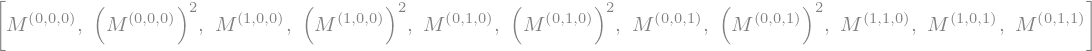

> Compute Moment Equations: computing equations for 11 moments
 [0:00:07.735980]
> Compute Moment Equations: computing equations for 15 moments
 [0:00:31.230535]
> Compute Moment Equations: computing equations for 15 moments
 [0:01:09.864667]
> Compute Moment Equations: computing equations for 8 moments
 [0:01:15.111072]
> Compute Moment Equations: computing equations for 11 moments
 [0:01:58.807773]
> Compute Moment Equations: computing equations for 4 moments
 [0:00:27.537143]
> Compute Moment Equations: computing equations for 1 moments
 [0:00:03.373644]
> Automated Moment Equations: #equations=65 [0:05:34.257442]


Computed moment equations for desired moments $\left< N\right> $, $\left< N^{2}\right> $, $\left< M^{\left(1, 0, 0\right)}\right> $, $\left< {\left(M^{\left(1, 0, 0\right)}\right)}^{\mathtt{\text{2}}}\right> $, $\left< M^{\left(0, 1, 0\right)}\right> $, $\left< {\left(M^{\left(0, 1, 0\right)}\right)}^{\mathtt{\text{2}}}\right> $, $\left< M^{\left(0, 0, 1\right)}\right> $, $\left< {\left(M^{\left(0, 0, 1\right)}\right)}^{\mathtt{\text{2}}}\right> $, $\left< M^{\left(1, 1, 0\right)}\right> $, $\left< M^{\left(1, 0, 1\right)}\right> $, and $\left< M^{\left(0, 1, 1\right)}\right> $.

Equations were iteratively added for $\left< N M^{\left(1, 1, 0\right)}\right> $, $\left< N M^{\left(1, 0, 1\right)}\right> $, $\left< M^{\left(0, 2, 0\right)}\right> $, $\left< M^{\left(0, 0, 1\right)} M^{\left(1, 0, 0\right)}\right> $, $\left< N M^{\left(0, 1, 1\right)}\right> $, $\left< M^{\left(0, 1, 0\right)} M^{\left(1, 1, 0\right)}\right> $, $\left< N M^{\left(1, 0, 0\right)}\right> $, $\left< N M^{\left(0, 1, 0\right)}\right> $, $\left< M^{\left(1, 0, 0\right)} M^{\left(1, 1, 0\right)}\right> $, $\left< N M^{\left(0, 0, 2\right)}\right> $, $\left< N M^{\left(0, 0, 1\right)}\right> $, $\left< M^{\left(0, 1, 0\right)} M^{\left(1, 0, 0\right)}\right> $, $\left< M^{\left(0, 0, 1\right)} M^{\left(0, 1, 0\right)}\right> $, $\left< M^{\left(2, 0, 0\right)}\right> $, $\left< M^{\left(0, 0, 2\right)}\right> $, $\left< M^{\left(0, 0, 1\right)} M^{\left(1, 1, 0\right)}\right> $, $\left< M^{\left(0, 0, 1\right)} M^{\left(1, 0, 1\right)}\right> $, $\left< M^{\left(0, 1, 1\right)} M^{\left(1, 0, 0\right)}\right> $, $\left< M^{\left(0, 0, 1\right)} M^{\left(0, 1, 1\right)}\right> $, $\left< N M^{\left(2, 0, 0\right)}\right> $, $\left< M^{\left(0, 1, 0\right)} M^{\left(1, 0, 1\right)}\right> $, $\left< M^{\left(0, 0, 1\right)} M^{\left(0, 0, 2\right)}\right> $, $\left< N M^{\left(0, 2, 0\right)}\right> $, $\left< M^{\left(1, 0, 0\right)} M^{\left(1, 0, 1\right)}\right> $, $\left< M^{\left(0, 1, 0\right)} M^{\left(2, 0, 0\right)}\right> $, $\left< {\left(M^{\left(1, 1, 0\right)}\right)}^{\mathtt{\text{2}}}\right> $, $\left< M^{\left(0, 2, 0\right)} M^{\left(1, 0, 0\right)}\right> $, $\left< M^{\left(0, 1, 0\right)} M^{\left(0, 1, 1\right)}\right> $, $\left< M^{\left(1, 0, 0\right)} M^{\left(2, 0, 0\right)}\right> $, $\left< M^{\left(0, 1, 0\right)} M^{\left(0, 2, 0\right)}\right> $, $\left< M^{\left(1, 1, 0\right)} M^{\left(2, 0, 0\right)}\right> $, $\left< M^{\left(0, 0, 1\right)} M^{\left(2, 0, 0\right)}\right> $, $\left< M^{\left(0, 2, 0\right)} M^{\left(1, 1, 0\right)}\right> $, $\left< M^{\left(0, 0, 2\right)} M^{\left(1, 0, 0\right)}\right> $, $\left< M^{\left(0, 0, 1\right)} M^{\left(0, 2, 0\right)}\right> $, $\left< M^{\left(1, 0, 1\right)} M^{\left(1, 1, 0\right)}\right> $, $\left< M^{\left(0, 0, 2\right)} M^{\left(0, 1, 0\right)}\right> $, $\left< M^{\left(0, 1, 1\right)} M^{\left(1, 1, 0\right)}\right> $, $\left< M^{\left(0, 0, 2\right)} M^{\left(1, 1, 0\right)}\right> $, $\left< M^{\left(0, 1, 1\right)} M^{\left(2, 0, 0\right)}\right> $, $\left< M^{\left(0, 1, 1\right)} M^{\left(0, 2, 0\right)}\right> $, $\left< {\left(M^{\left(0, 1, 1\right)}\right)}^{\mathtt{\text{2}}}\right> $, $\left< M^{\left(0, 2, 0\right)} M^{\left(2, 0, 0\right)}\right> $, $\left< M^{\left(0, 2, 0\right)} M^{\left(1, 0, 1\right)}\right> $, $\left< M^{\left(1, 0, 1\right)} M^{\left(2, 0, 0\right)}\right> $, $\left< {\left(M^{\left(0, 2, 0\right)}\right)}^{\mathtt{\text{2}}}\right> $, $\left< {\left(M^{\left(1, 0, 1\right)}\right)}^{\mathtt{\text{2}}}\right> $, $\left< M^{\left(0, 1, 1\right)} M^{\left(1, 0, 1\right)}\right> $, $\left< {\left(M^{\left(2, 0, 0\right)}\right)}^{\mathtt{\text{2}}}\right> $, $\left< M^{\left(0, 0, 2\right)} M^{\left(1, 0, 1\right)}\right> $, $\left< M^{\left(0, 0, 2\right)} M^{\left(0, 2, 0\right)}\right> $, $\left< M^{\left(0, 0, 2\right)} M^{\left(2, 0, 0\right)}\right> $, $\left< M^{\left(0, 0, 2\right)} M^{\left(0, 1, 1\right)}\right> $, and $\left< {\left(M^{\left(0, 0, 2\right)}\right)}^{\mathtt{\text{2}}}\right> $.

In [5]:
M = Moment
moments = [
    M(0,0,0),
    M(0,0,0)**2,
    M(1,0,0),
    M(1,0,0)**2,
    M(0,1,0),
    M(0,1,0)**2,
    M(0,0,1),
    M(0,0,1)**2,
    M(1,1,0),
    M(1,0,1),
    M(0,1,1),
]
display(moments)
equations = automated_moment_equations(3, transitions, moments, lpac=True, order=2)
# display_moment_equations(equations)

In [6]:
len(equations)

The LaTeX source of the ODE system can be found and copy-pasted by modifying the Math Render option of the jupyter notebook. This is done by right-clicking on the system and choosing Math Settings > Math Render > Plain Source .

From the closed equations, we can also generate code to simulate the system. Currently, Python or Julia code can be generated.

For a direct code output, the user can rely on the functions:

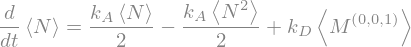

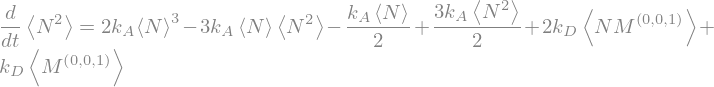

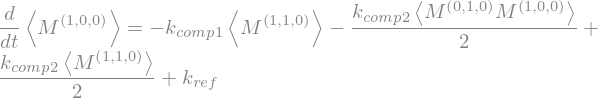

**The system is not closed!** Moment equations are missing for:

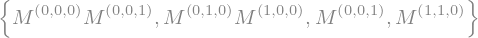

In [7]:
display_moment_equations(equations[:3])

In [8]:
name = "SAIC"
julia_code = generate_julia_code(equations, function_name=name)
print(julia_code)
filename=name+".jl"
with open(filename, 'w') as f:
    print(julia_code, file=f)
    print("Code written to file: %s" %(filename))

> Generating ODE body...
>> (1) Generating RHS code for Moment(0, 0, 0)...
>>> Generating RHS code... [0:00:00.000166]
>>> Generating RHS comments...
>> (2) Generating RHS code for Moment(0, 0, 0)**2...
>>> Generating RHS code... [0:00:00.000406]
>>> Generating RHS comments...
>> (3) Generating RHS code for Moment(1, 0, 0)...
>>> Generating RHS code... [0:00:00.000350]
>>> Generating RHS comments...
>> (4) Generating RHS code for Moment(1, 0, 0)**2...
>>> Generating RHS code... [0:00:00.000493]
>>> Generating RHS comments...
>> (5) Generating RHS code for Moment(0, 1, 0)...
>>> Generating RHS code... [0:00:00.000154]
>>> Generating RHS comments...
>> (6) Generating RHS code for Moment(0, 1, 0)**2...
>>> Generating RHS code... [0:00:00.000327]
>>> Generating RHS comments...
>> (7) Generating RHS code for Moment(0, 0, 1)...
>>> Generating RHS code... [0:00:00.000157]
>>> Generating RHS comments...
>> (8) Generating RHS code for Moment(0, 0, 1)**2...
>>> Generating RHS code... [0:00:00.00

# evaluate ODEs
function SAIC_ODEs(dM, M, parameters, t)
  c3 = parameters[:k1] # k1
  c6 = parameters[:k2] # k2
  c8 = parameters[:kA] # kA
  c0 = parameters[:kD] # kD
  c1 = parameters[:kact] # kact
  c2 = parameters[:kcomp1] # kcomp1
  c4 = parameters[:kcomp2] # kcomp2
  c5 = parameters[:kmeas] # kmeas
  c7 = parameters[:kref] # kref
  # Number of Compartments (N)
  dM[1] = c0*M[7]+1/2*c8*M[1]-1/2*c8*M[2]
  # N^2
  dM[2] = c0*M[7]+2*c8*((M[1])^(3))+2*c0*M[22]-1/2*c8*M[1]+3/2*c8*M[2]-3*c8*M[2]*M[1]
  # Total Mass of species 1
  dM[3] = c7+1/2*c4*M[9]-c2*M[9]-1/2*c4*M[23]
  # M1^2
  dM[4] = c7+c2*M[9]+c4*M[20]+1/2*c4*M[23]-2*c2*M[20]+2*c7*M[3]-1/2*c4*M[9]-c4*M[4]*M[5]-2*c4*M[23]*M[3]+2*c4*((M[3])^(2))*M[5]
  # Total Mass of species 2
  dM[5] = c5*M[7]+1/2*c4*M[9]-c2*M[9]-1/2*c4*M[23]
  # M2^2
  dM[6] = c2*M[9]+c4*M[17]+c5*M[7]+1/2*c4*M[23]-2*c2*M[17]+2*c5*M[24]-1/2*c4*M[9]-c4*M[6]*M[3]-2*c4*M[23]*M[5]+2*c4*((M[5])^(2))*M[3]
  # Total Mass of species 3
  dM[7] = c3*M[1]+c1*M[18]+1/2*c8